In [1]:
from darli.models.robot_model import RobotModel
import matplotlib.pyplot as plt
import casadi as cs
import numpy as np

In [2]:
urdf_file = '../yet_another_menagerie/z1/z1.urdf'
darli_model = RobotModel(urdf_file, bodies_names={'ee': 'link06'})

In [3]:
nq = darli_model.nq
nv = darli_model.nv
nu = darli_model.nu

Time intervals (nodes):

In [4]:
ns = 50  # number of shooting nodes

Create problem instance, configuration and control variables:

In [5]:
opti_problem = cs.Opti()
state = opti_problem.variable(nq + nv, ns+1) # state of the system
q = state[:nq, :]
dq = state[nq:, :]
u = opti_problem.variable(nv,ns+1)


In [6]:
# tf = 1.5  # [s]
tf = opti_problem.variable(1)


In [7]:
dt = tf/ns

In [8]:
f = darli_model.state_space.state_derivative

In [9]:
dt = tf/ns # length of a intervals
# form contraints
for k in range(ns):
  state_next = state[:,k] + dt*(f(state[:,k], u[:, k]) + f(state[:,k+1], u[:, k+1]))/2
  opti_problem.subject_to(state[:,k+1] == state_next)

Create parametric initial and final points (joint and cartesian spaces):

In [10]:
initial_configuration = opti_problem.parameter(6)
desired_pos = opti_problem.parameter(3)

Setup the boundary conditions:

In [11]:
# initial point (joint space)
opti_problem.subject_to(q[:,0] == initial_configuration)
opti_problem.subject_to(dq[:,0] == np.zeros(darli_model.nv))
# Terminal point (cartesian space)
opti_problem.subject_to(dq[:,-1] == np.zeros(darli_model.nv))

opti_problem.subject_to(darli_model.body('ee').position(q[:,-1]) == desired_pos)


Cost quadrature approximation:

In [12]:
# cost
cost = 0 
cost += 100*tf
# stage cost 
for k in range(ns-1):
    cost += 1e-2*cs.sumsqr(q[:,k])#*dt
    cost += 1e-1*cs.sumsqr(dq[:,k])#*dt
    cost += 0.01*cs.sumsqr(u[:,k])#*dt
    
# Terminal cost 
cost += 5e-1*cs.sumsqr(q[:,-1])
cost += 10e-1*cs.sumsqr(dq[:,-1])
cost += 0.01*cs.sumsqr(u[:,-1])

Setup the limits:

In [13]:
# Limits 
# joint limits 
opti_problem.subject_to(opti_problem.bounded(darli_model.q_min, q, darli_model.q_max))
# velocity limits
v_max = 1.5
qdot_lims = np.full((nv), v_max)
opti_problem.subject_to(opti_problem.bounded(-qdot_lims, dq,  qdot_lims))
# torque limits
u_max = 5
u_lims = np.full((nu), u_max) 
opti_problem.subject_to(opti_problem.bounded(-u_max, u,  u_max))

if type(tf) is cs.casadi.MX:
    opti_problem.subject_to(tf>=0.001)

Define numerical values for the parameters and solve:

In [14]:
opti_problem.set_value(initial_configuration,np.zeros(6))
opti_problem.set_value(desired_pos,[0.3, 0.1, 0.36])

In [15]:
opti_problem.minimize(cost)
# opti_problem.solver('sqpmethod')
opti_problem.solver('ipopt')

In [16]:

if type(tf) is cs.casadi.MX:
    opti_problem.set_initial(tf,0.5)

In [17]:
sol = opti_problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    12032
Number of nonzeros in inequality constraint Jacobian.:      919
Number of nonzeros in Lagrangian Hessian.............:     6117

Total number of variables............................:      919
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      621
Total number of inequality c

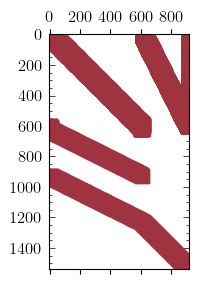

In [32]:


# plt.spy(sol.value(cs.jacobian(opti_problem.g,opti_problem.x)))
# plt.show()

In [19]:
q_opt = opti_problem.value(q).T
dq_opt = opti_problem.value(dq).T
u_opt = opti_problem.value(u).T

if type(tf) is cs.casadi.MX:
    tf_opt = opti_problem.value(tf)
else:
    tf_opt = tf
# q_opt

In [20]:
tf_opt

1.183152831263313

In [21]:
darli_model.body('ee').position(q_opt[-1]), opti_problem.value(desired_pos)

(DM([0.3, 0.1, 0.36]), array([0.3 , 0.1 , 0.36]))

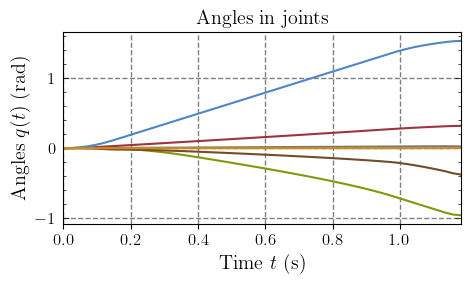

In [25]:
t = np.linspace(0, tf_opt, ns+1)


plt.title(r'Angles in joints')
plt.plot(t, q_opt)
plt.xlim([0, tf_opt])
plt.grid(True)
plt.ylabel(r'Angles $q(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

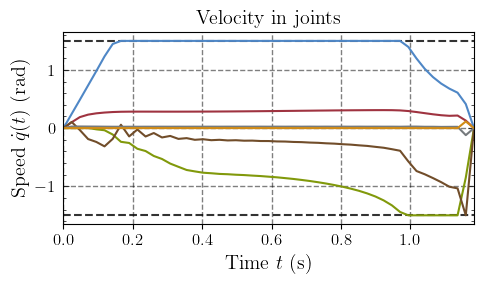

In [29]:
plt.title(r'Velocity in joints')
plt.hlines(-v_max, 0, tf_opt, color = 'black', linestyle = '--', alpha = 0.8)
plt.hlines(v_max, 0, tf_opt, color = 'black', linestyle = '--', alpha = 0.8)
plt.plot(t, dq_opt)
plt.grid(True)
plt.ylabel(r'Speed $\dot{q}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

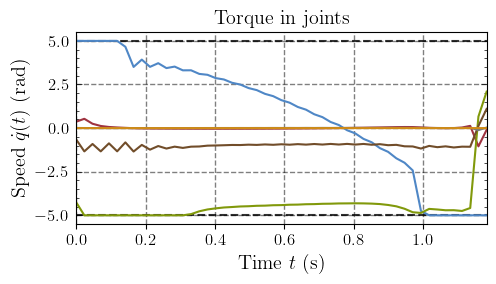

In [31]:

plt.title(r'Torque in joints')
plt.hlines(-u_max, 0, tf_opt, color = 'black', linestyle = '--', alpha = 0.8)
plt.hlines(u_max, 0, tf_opt, color = 'black', linestyle = '--', alpha = 0.8)
plt.plot(t, u_opt)
plt.grid(True)
plt.ylabel(r'Speed $\dot{q}(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()